In [1]:
from useful_scit.imps import *
import wrf 
from netCDF4 import Dataset
from sklearn.cluster import KMeans

In [8]:
def import_ds(path,var):
    files = glob.glob(path)
    files.sort()
    ncs = [Dataset(f) for f in files]
    tc = wrf.getvar(ncs,'tc',timeidx=wrf.ALL_TIMES, method="cat")
    z = wrf.getvar(ncs,'z',timeidx=wrf.ALL_TIMES, method="cat")
    tc['height']=z
    ds = tc.to_dataset()
    return ds
    

In [307]:
def cluster_ds_raw(ds, clus_num, var, var_name):
    tc1 = ds[var_name].to_series()
    tc1 = tc1.unstack(level='Time').dropna(axis=0,how='all')
    kmeans = KMeans(n_clusters=clus_num, random_state=0).fit(tc1)
    tc1['lab']=kmeans.labels_
    lab_da = tc1['lab'].to_xarray()
    labs = tc1['lab'].unique()
    labs.sort()
    labs
    ds['clus_lab'] = lab_da
    return {'ds':ds, 'labs':labs} 

In [86]:
def find_bot_top(ds,i):
    dsi = ds[var_name].where(ds['clus_lab']==i)
    dsi
    b_t = ds.bottom_top
    dic = dsi.count(dim=['Time','south_north','west_east'])
    bot_top_val = (b_t*dic).sum()/dic.sum()
    bot_top_val
    return i , bot_top_val

In [260]:
def get_sorted_labs(ds,labs):
    lab_dic = {}
    for i in labs:
        nn,tb = find_bot_top(ds,i)
        lab_dic[i]= float(tb)
    df = pd.DataFrame(lab_dic,['bt']).T
    df['old_lab']=df.index
    df=df.sort_values('bt').reset_index(drop=True)
    df['new_lab']=df.index
    return df

In [244]:
def ds_fix_cluster_lab(ds_i,df):
    ds = ds_i.copy()
    ds['old_lab'] = ds.clus_lab.copy()
    ds['new_lab'] = ds.clus_lab.copy()
    for l,r in df.iterrows():
        ds['i'] = r.new_lab
        ds['new_lab']= ds['i'].where(ds.old_lab==r.old_lab,ds['new_lab'])
    ds = ds.drop(['old_lab','i'])
    ds['new_lab']=ds.new_lab.astype(int)
    return ds

In [224]:
def cluster_ds(path, clus_num, var, var_name):
    ds = import_ds(path,var)
    res = cluster_ds_raw(ds,clus_num,var, var_name)
    ds = res['ds']
    labs = res['labs'] 
    df = get_sorted_labs(ds,labs)
    ds1 = ds_fix_cluster_lab(ds,df)
    return ds1 

    
    

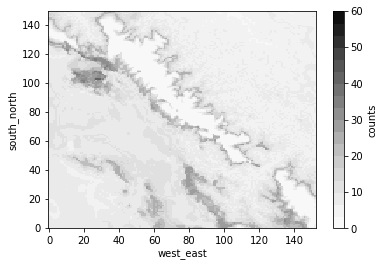

In [349]:
cmap=matplotlib.colors.ListedColormap(sns.color_palette('Greys',18))
dsi = ds2[var_name].where(ds2.clus_lab==i)
plt.subplots()
dsc = dsi.count(dim=['Time','bottom_top'])
dsc.name = 'counts'
dsc.plot.imshow(vmin=0,vmax=tot_max,
                cmap=cmap)

In [337]:
tot = ds2[var_name].count()
tot_max = ds2[var_name].count(dim=['Time','bottom_top']).max()
grid_max = dsc.max()

In [339]:
tot_max

<xarray.DataArray 'temp' ()>
array(60)

In [341]:
sns.choose_colorbrewer_palette('d')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

[(0.6922722029988467, 0.09227220299884642, 0.16770472895040373),
 (0.8392156862745099, 0.376470588235294, 0.3019607843137253),
 (0.9545559400230679, 0.641753171856978, 0.5057285659361783),
 (0.9921568627450982, 0.8588235294117645, 0.7803921568627449),
 (0.9657054978854286, 0.9672433679354094, 0.9680891964628989),
 (0.8196078431372551, 0.8980392156862745, 0.9411764705882353),
 (0.5664744329104192, 0.7687043444828916, 0.8685121107266438),
 (0.26274509803921564, 0.576470588235294, 0.7647058823529411),
 (0.1272587466359093, 0.39584775086505203, 0.6687427912341407)]

In [346]:
cmBuRd = mpl.colors.ListedColormap(sns.color_palette('RdBu_r',18))